In [1]:
import numpy as np
import gc


class MyKMeans:
    """Simple realisation of K-Means algorithm, using 3 methods of initialisation:
    1) 'random' -- cluster centers are initialised with random samples from selection;
    2) 'max_distances' -- first cluster center is initialised with random sample and all the
    others are initialised with the sample that is as remote as possible from previous centers;
    3) 'k-means++' -- quite known algorithm of initialisation, you can
    read about it at https://en.wikipedia.org/wiki/K-means%2B%2B.
    """
    def __init__(self, random_state=0, n_clusters=3, heuristic='random', max_iter=300):
        self.random_state = random_state

        assert n_clusters > 0, "Parameter 'n_clusters' should be positive"
        self.n_clusters = n_clusters

        assert heuristic in ('random', 'max_distances', 'k-means++'), \
            "Parameter 'heuristic' should be one of ('random', 'max_distances', 'k-means++')"

        self.heuristic = heuristic

        assert max_iter > 0, "Parameter 'max_iter' should be positive"
        self.max_iter = max_iter

        self.n_iters_ = 0
        self.labels_ = np.empty(0)
        self.cluster_centers_ = np.ones(shape=self.n_clusters, dtype=object)

    def fit(self, data):
        shape = data.shape[0]
        np.random.seed(self.random_state)
        self.labels_ = np.empty(shape, dtype='int32')
        if self.heuristic == "random":
            # just selecting random samples
            for idx in range(self.n_clusters):
                self.cluster_centers_[idx] = data[np.random.randint(shape, size=1), :]
        elif self.heuristic == 'k-means++':
            self.cluster_centers_[0] = data[np.random.randint(shape, size=1), :]
            distances = np.ndarray(shape)
            for cluster in range(self.n_clusters)[1:]:
                for idx, x in enumerate(data):
                    # assigning every sample the minimum distance from existing centers
                    distances[idx] = np.amin(np.array(list(map(lambda y: np.linalg.norm(y - x),
                                                               self.cluster_centers_[:cluster]))))
                rnd = np.random.random() * sum(distances)
                cum_sum = 0
                center = data[0, :].copy()
                for idx, x in enumerate(data):
                    # searching for the sample, which probability
                    # is proportional to its distance
                    center = x.copy()
                    cum_sum += distances[idx]
                    if cum_sum >= rnd:
                        break
                self.cluster_centers_[cluster] = center
        else:
            # finding samples that are as far as they could be from previous centers
            self.cluster_centers_[0] = data[np.random.randint(shape, size=1), :]
            distances = np.zeros(shape)
            for idx in range(self.n_clusters)[1:]:
                for cluster in range(idx):
                    distances += np.array(list(map(lambda x: np.linalg.norm(x -
                                                                            self.cluster_centers_[cluster]), data)))
                    self.cluster_centers_[idx] = data[distances.argmax(), :]
        while self.n_iters_ < self.max_iter:
            # assigning samples with labels
            for idx, x in enumerate(data):
                self.labels_[idx] = np.array(list(map(lambda y: np.linalg.norm(x - y),
                                                      self.cluster_centers_))).argmin()

            # recomputing the cluster centers
            for cluster in range(self.n_clusters):
                cardinality = sum(self.labels_ == cluster)
                if cardinality != 0:
                    self.cluster_centers_[cluster] = sum(data[self.labels_ == cluster]) / cardinality
            self.n_iters_ += 1
        gc.collect()
        return self

    def predict(self, data):
        assert len(self.cluster_centers_[0]) == data.shape[1]
        self.labels_ = np.ndarray(data.shape[0])
        for idx, x in enumerate(data):
            self.labels_[idx] = int(np.array(list(map(lambda y: np.linalg.norm(x - y),
                                                  self.cluster_centers_))).argmin())
        gc.collect()
        return self.labels_

    def fit_predict(self, data):
        self.fit(data)
        return self.predict(data)

    def get_params(self):
        return {
            'random_state': self.random_state,
            'n_clusters': self.n_clusters,
            'heuristic': self.heuristic,
            'max_iter': self.max_iter
        }

In [2]:
from sklearn.datasets import make_blobs
# import dataset maker
from sklearn.cluster import KMeans
# import sklearn version of algorithm to compare

import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('seaborn-dark')

import warnings
warnings.filterwarnings("ignore")

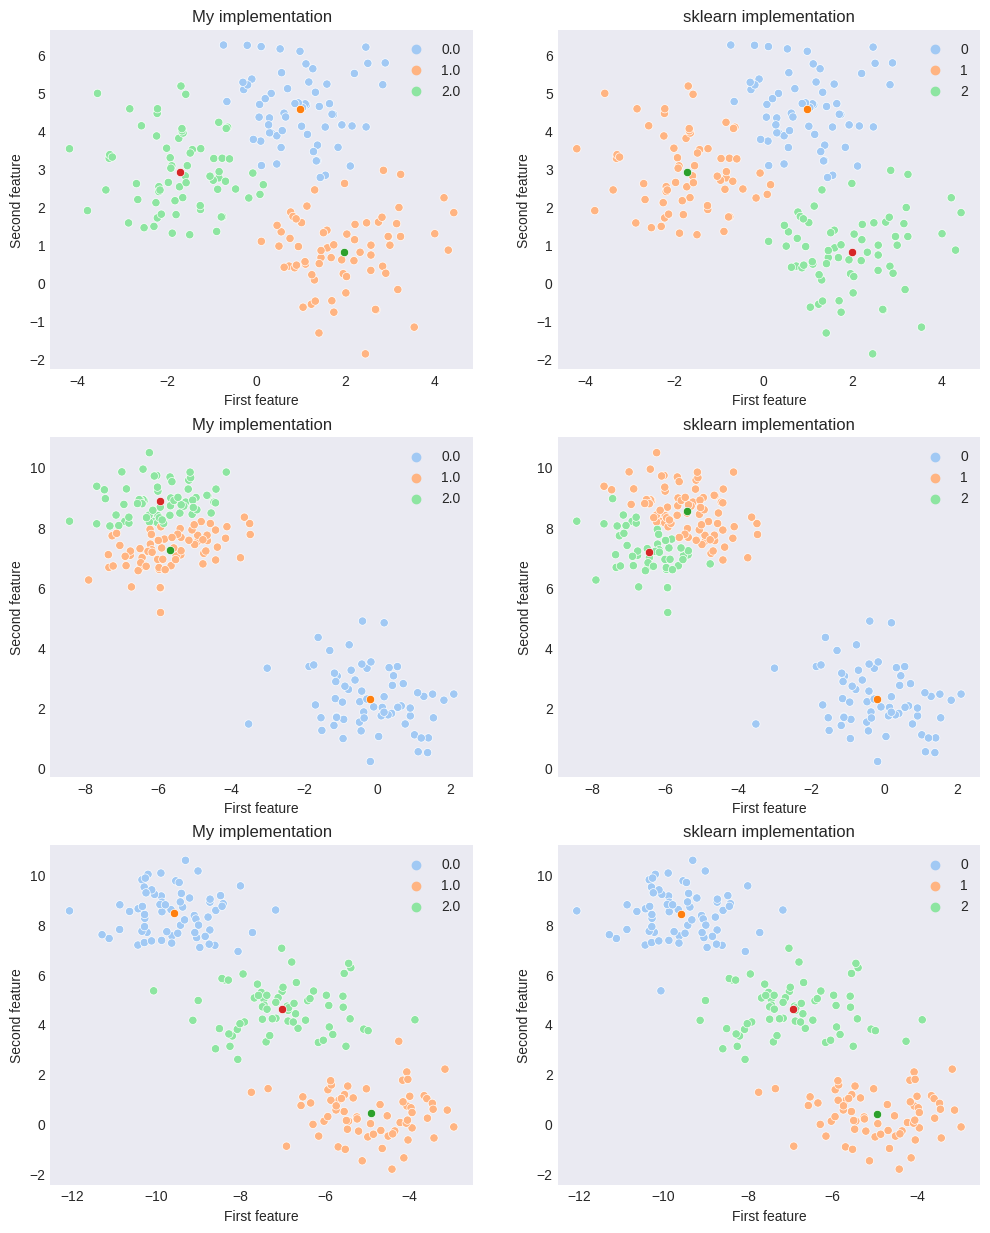

In [3]:
# comparing the results of realisations of k-means
# on different datasets, using 'k-means++' initialisation
fig, ax = plt.subplots(nrows=3, ncols=2, figsize=(12, 15))
for row, sample_seed in enumerate([0, 5, 12]):
    X, y = make_blobs(n_samples=200, n_features=2, centers=3, random_state=sample_seed)
    a = MyKMeans(n_clusters=3, random_state=0, heuristic='k-means++').fit(X)
    b = KMeans(n_clusters=3, random_state=0, init='k-means++').fit(X)
    for column, implementation in enumerate([(a, "My implementation"), (b, "sklearn implementation")]):
        sns.scatterplot(x=X[:, 0], y=X[:, 1], hue=implementation[0].predict(X), palette='pastel', ax=ax[row, column])
        ax[row, column].set_xlabel("First feature")
        ax[row, column].set_ylabel("Second feature")
        for center in range(implementation[0].n_clusters):
            # marking cluster centers
            sns.scatterplot(x=[implementation[0].cluster_centers_[center][0]],
                            y=[implementation[0].cluster_centers_[center][1]], ax=ax[row, column])
        ax[row, column].set_title(implementation[1])
plt.show()